# DEEP LEARNING ASSIGNMENT 8

# RACHIT AGGARWAL = M12506500

## Importing required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

C:\Users\rachi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## 8 (a).

In [2]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

## 8 (b).

In [5]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [6]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [7]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.190826	Best loss: 0.190826	Accuracy: 96.64%
1	Validation loss: 1.689649	Best loss: 0.190826	Accuracy: 18.73%
2	Validation loss: 1.660114	Best loss: 0.190826	Accuracy: 20.91%
3	Validation loss: 1.778077	Best loss: 0.190826	Accuracy: 22.01%
4	Validation loss: 1.667106	Best loss: 0.190826	Accuracy: 22.01%
5	Validation loss: 1.654532	Best loss: 0.190826	Accuracy: 22.01%
6	Validation loss: 1.680933	Best loss: 0.190826	Accuracy: 18.73%
7	Validation loss: 1.779077	Best loss: 0.190826	Accuracy: 22.01%
8	Validation loss: 1.699482	Best loss: 0.190826	Accuracy: 19.27%
9	Validation loss: 1.767771	Best loss: 0.190826	Accuracy: 20.91%
10	Validation loss: 1.629350	Best loss: 0.190826	Accuracy: 22.01%
11	Validation loss: 1.812643	Best loss: 0.190826	Accuracy: 22.01%
12	Validation loss: 1.675939	Best loss: 0.190826	Accuracy: 18.73%
13	Validation loss: 1.633259	Best loss: 0.190826	Accuracy: 20.91%
14	Validation loss: 1.652904	Best loss: 0.190826	Accuracy: 20.91%
15	Validation loss: 

## 9 (a).

In [8]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_mnist_model_0_to_4.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [9]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [10]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

## 9 (b).

In [11]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

In [12]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [13]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [14]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
0	Validation loss: 1.428894	Best loss: 1.428894	Accuracy: 47.33%
1	Validation loss: 1.278391	Best loss: 1.278391	Accuracy: 49.33%
2	Validation loss: 1.166970	Best loss: 1.166970	Accuracy: 52.67%
3	Validation loss: 1.308910	Best loss: 1.166970	Accuracy: 49.33%
4	Validation loss: 1.133370	Best loss: 1.133370	Accuracy: 54.67%
5	Validation loss: 1.264265	Best loss: 1.133370	Accuracy: 50.67%
6	Validation loss: 1.167142	Best loss: 1.133370	Accuracy: 52.67%
7	Validation loss: 1.201874	Best loss: 1.133370	Accuracy: 52.00%
8	Validation loss: 1.233133	Best loss: 1.133370	Accuracy: 51.33%
9	Validation loss: 1.144155	Best loss: 1.133370	Accuracy: 56.00%
10	Validation loss: 1.203532	Best loss: 1.133370	Accuracy: 54.00%
11	Validation loss: 1.225048	Best loss: 1.133370	Accuracy: 54.67%
12	Validation loss: 1.110734	Best loss: 1.110734	Accuracy: 53.33%
13	Validation loss: 1.260934	Best loss: 1.110734	Accuracy: 53.33%
14	Validation l

## Determining correctly and missclassfied instances

In [15]:
with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    prediction = correct.eval(feed_dict={X: X_test2, y: y_test2})  

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_five_frozen


In [16]:
prediction

array([False,  True, False, ...,  True, False,  True])

## Separating instances

In [17]:
df = pd.DataFrame(prediction, columns=['pred'])
X_test2_df = pd.DataFrame(X_test2)
new_df = pd.concat((df, X_test2_df),axis=1)

In [18]:
correctly_classified = new_df[new_df.pred == True]
miss_classified = new_df[new_df.pred == False]

In [19]:
correctly_classified = correctly_classified.drop(['pred'], axis=1)
miss_classified = miss_classified.drop(['pred'], axis=1)

## Selecting 100 correct and 100 missclassified examples

In [20]:
correct_calss = correctly_classified[:100].as_matrix()
wrong_calss = miss_classified[:100].as_matrix()

In [21]:
wrong_calss.shape

(100, 784)

## Ploting a random correctly classified instance

(-0.5, 27.5, 27.5, -0.5)

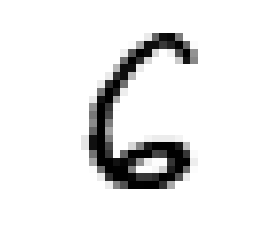

In [26]:
plt.imshow(correct_calssi_mat[28,:].reshape(28,28),cmap='binary')
plt.axis("off")

## Ploting a random wrongly classified instance

(-0.5, 27.5, 27.5, -0.5)

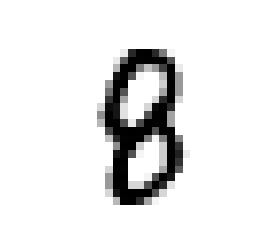

In [27]:
plt.imshow(wrong_calssi_mat[28,:].reshape(28,28),cmap='binary')
plt.axis("off")